In [ ]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import seaborn as sns
from topmed_manuscript_clean import format_modality
import sys
from fastcluster import linkage as fastcluster_linkage
from scipy.cluster.hierarchy import linkage as scipy_linkage
sys.setrecursionlimit(100000)


# convert hex to rgb
def hex_to_rgb(value):
    value = value.lstrip('#')
    lv = len(value)
    return tuple(int(value[i:i + lv // 3], 16) for i in range(0, lv, lv // 3))

def parse_index(x):
    i = re.match('(.*) (cis|trans)(.*)', x).groups()
    return {'tissue': i[0], 'modality': i[1] + i[2]}

PREFIX = 'Fig4B.'
COLOCS = '/net/topmed11/working/porchard/rnaseq-2024-10-16-sample-update/manuscript-intermediate-processing/work/coloc/panukbb/joint/postprocessed.txt'
GWAS_CS = '/net/topmed11/working/porchard/panukbb-finemapping/work/ancestry-specific-finemapping/lift-susie/results/susie-cs-and-convergence/gwas.cs.txt'

/net/snowwhite/home/porchard/anaconda3/envs/2020-09/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:7: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
/net/snowwhite/home/porchard/anaconda3/envs/2020-09/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:7: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,


In [2]:
# load up the colocs
colocs = pd.read_csv(COLOCS, sep='\t')
colocs.head()

,nsnps,hit1,hit2,PP.H0.abf,PP.H1.abf,PP.H2.abf,PP.H3.abf,PP.H4.abf,idx1,idx2,...,xqtl_modality,xqtl_tissue,xqtl_maf,xqtl_phenotype,xqtl_ancestry,xqtl_gene,gwas_region,gwas_ancestry,gwas_trait,gwas_signal
0,3038,chr19_43648948_A_G,chr19_43648948_A_G,9.685129e-90,8.535842e-37,2.269285e-56,0.000000e+00,1.0,4,1,...,ciseqtl,Whole_blood,0.1%,ENSG00000105767.3,joint,ENSG00000105767.3,chr19_43398947_43898948,EUR,continuous-30180-both_sexes-irnt,continuous-30180-both_sexes-irnt___EUR___chr19...
1,3795,chr7_28237488_C_G,chr7_28237488_C_G,1.050548e-256,1.197983e-60,1.753861e-199,4.638423e-14,1.0,1,2,...,ciseqtl,Monocyte,1%,ENSG00000234336.6,joint,ENSG00000234336.6,chr7_27987487_28934757,EUR,continuous-30180-both_sexes-irnt,continuous-30180-both_sexes-irnt___EUR___chr7_...
2,3795,chr7_28237488_C_G,chr7_28237488_C_G,0.000000e+00,1.000035e-72,9.804506e-314,0.000000e+00,1.0,1,2,...,ciseqtl,Monocyte,1%,ENSG00000153814.13,joint,ENSG00000153814.13,chr7_27987487_28934757,EUR,continuous-30200-both_sexes-irnt,continuous-30200-both_sexes-irnt___EUR___chr7_...
3,6075,chr7_28237488_C_G,chr7_28237488_C_G,0.000000e+00,1.197983e-60,0.000000e+00,4.638423e-14,1.0,1,2,...,ciseqtl,Whole_blood,0.1%,ENSG00000153814.13,joint,ENSG00000153814.13,chr7_27987487_28934757,EUR,continuous-30180-both_sexes-irnt,continuous-30180-both_sexes-irnt___EUR___chr7_...
4,3852,chr3_56815721_T_C,chr3_56815721_T_C,0.000000e+00,0.000000e+00,3.401943e-23,0.000000e+00,1.0,1,1,...,transeqtl,Whole_blood,5%,ENSG00000134548.11,joint,ENSG00000134548.11,chr3_55736130_58845977,EUR,continuous-30080-both_sexes-irnt,continuous-30080-both_sexes-irnt___EUR___chr3_...


In [3]:
# load up all the GWAS signals
gwas_cs = pd.read_csv(GWAS_CS, sep='\t', header=None, names=['variant_id', 'cs_id', 'pip', 'gwas_signal'])
gwas_cs.head()

,variant_id,cs_id,pip,gwas_signal
0,chr17_40608272_T_A,L1,0.999999,categorical-6152-both_sexes-100___EUR___chr17_...
1,chr17_39872381_G_T,L2,0.003558,categorical-6152-both_sexes-100___EUR___chr17_...
2,chr17_39886524_T_A,L2,0.003599,categorical-6152-both_sexes-100___EUR___chr17_...
3,chr17_39887090_G_A,L2,0.003599,categorical-6152-both_sexes-100___EUR___chr17_...
4,chr17_39891991_T_C,L2,0.003592,categorical-6152-both_sexes-100___EUR___chr17_...


In [4]:
# max PP4 per GWAS signal per scan
max_pp4 = colocs.groupby(['gwas_cs', 'xqtl_modality', 'xqtl_tissue', 'xqtl_maf', 'gwas_region', 'gwas_ancestry', 'gwas_trait', 'gwas_signal'])['PP.H4.abf'].max().rename('max_pp4').reset_index()
max_pp4['xqtl'] = max_pp4.xqtl_modality + '___' + max_pp4.xqtl_tissue + '___' + max_pp4.xqtl_maf
max_pp4 = max_pp4.pivot(index=['gwas_signal', 'gwas_cs'], columns='xqtl', values='max_pp4').reset_index()
max_pp4 = gwas_cs[['gwas_signal', 'cs_id']].rename(columns={'cs_id': 'gwas_cs'}).drop_duplicates().merge(max_pp4, how='left')
max_pp4 = max_pp4.set_index(['gwas_signal', 'gwas_cs']).fillna(0).reset_index()
max_pp4 = max_pp4[max_pp4.gwas_signal.str.contains('___EUR___')]
max_pp4 = max_pp4[[i for i in max_pp4.columns if '0.1%' not in i]]
max_pp4.index = max_pp4.gwas_signal + '___' + max_pp4.gwas_cs
max_pp4 = max_pp4.drop(columns=['gwas_signal', 'gwas_cs'])
max_pp4.columns = ['{} {}'.format(i.split('___')[1].replace('_', ' '), format_modality(i.split('___')[0])) for i in max_pp4.columns.to_list()]
max_pp4.head()

,Lung cis-eQTL,Monocyte cis-eQTL,Nasal epithelial cis-eQTL,PBMC cis-eQTL,T cell cis-eQTL,Whole blood cis-eQTL,Lung cis-sQTL,Monocyte cis-sQTL,Nasal epithelial cis-sQTL,PBMC cis-sQTL,T cell cis-sQTL,Whole blood cis-sQTL,Lung trans-eQTL,Monocyte trans-eQTL,Nasal epithelial trans-eQTL,PBMC trans-eQTL,Whole blood trans-eQTL,PBMC trans-sQTL,Whole blood trans-sQTL
categorical-6152-both_sexes-100___EUR___chr17_39401444_40858272___L1,0.000000,0.000000,0.000000,0.0,0.000000,1.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
categorical-6152-both_sexes-100___EUR___chr17_39401444_40858272___L2,0.949712,0.880657,0.934077,0.0,0.000000,0.0,0.943619,0.0,0.952353,0.947119,0.918775,0.948783,0.0,0.0,0.0,0.0,0.0,0.0,0.0
categorical-6152-both_sexes-100___EUR___chr17_39401444_40858272___L3,0.000000,0.000000,0.000000,0.0,0.881207,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
categorical-6152-both_sexes-100___EUR___chr17_42012843_42777380___L1,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
categorical-6152-both_sexes-100___EUR___chr17_4368177_4868178___L1,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
# cases where max PP4 is >= 0.8 (i.e., colocs)
max_pp4_colocs = max_pp4[max_pp4.max(axis=1)>=0.8]
max_pp4_colocs = max_pp4_colocs.T
max_pp4_colocs.head()

,categorical-6152-both_sexes-100___EUR___chr17_39401444_40858272___L1,categorical-6152-both_sexes-100___EUR___chr17_39401444_40858272___L2,categorical-6152-both_sexes-100___EUR___chr17_39401444_40858272___L3,categorical-6152-both_sexes-100___EUR___chr17_44849435_45628874___L2,categorical-6152-both_sexes-100___EUR___chr19_16857052_17357055___L1,categorical-6152-both_sexes-100___EUR___chr19_51575256_52075257___L1,categorical-6152-both_sexes-100___EUR___chr19_7363601_7863602___L1,categorical-6152-both_sexes-100___EUR___chr20_53345733_53845734___L1,categorical-6152-both_sexes-100___EUR___chr20_53928999_54429000___L1,categorical-6152-both_sexes-100___EUR___chr20_63451284_63951285___L1,...,icd10-N81-both_sexes___EUR___chr2_20428343_20928345___L1,icd10-N81-both_sexes___EUR___chr22_37948491_38448494___L1,icd10-N81-both_sexes___EUR___chr2_55618858_56118859___L1,phecode-459-both_sexes___EUR___chr19_10380658_10880659___L1,phecode-459-both_sexes___EUR___chr9_133024112_133534378___L1,phecode-574-both_sexes___EUR___chr10_45207296_45931516___L1,phecode-574-both_sexes___EUR___chr19_48453159_48953160___L1,phecode-574-both_sexes___EUR___chr2_42985822_45366360___L3,phecode-574-both_sexes___EUR___chr4_150027927_151253885___L1,phecode-574-both_sexes___EUR___chr7_86978036_87729921___L1
Lung cis-eQTL,0.0,0.949712,0.000000,0.000000,0.0,0.0,0.974451,0.912942,0.0,0.947543,...,0.993118,0.000000,0.942109,0.000000,0.0,0.000000,0.980010,0.989617,0.0,0.000000
Monocyte cis-eQTL,0.0,0.880657,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000
Nasal epithelial cis-eQTL,0.0,0.934077,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,...,0.000000,0.000000,0.000000,0.941507,0.0,0.000000,0.978997,0.000000,0.0,0.000000
PBMC cis-eQTL,0.0,0.000000,0.000000,0.977565,0.0,0.0,0.000000,0.000000,0.0,0.899868,...,0.000000,0.862198,0.000000,0.000000,0.0,0.969147,0.978996,0.000000,0.0,0.938822
T cell cis-eQTL,0.0,0.000000,0.881207,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,...,0.000000,0.000000,0.000000,0.942367,0.0,0.000000,0.980415,0.000000,0.0,0.000000


In [6]:
# example shown in Fig 4C
QTL_TISSUE = 'Whole_blood'
QTL_MAF = '1%'
QTL_GENE = 'ENSG00000134460.17'
QTL_MODALITY = 'cis-eQTL'
GWAS_TRAIT = 'continuous-AG-both_sexes-irnt'
GWAS_REGION = 'chr10_5803964_6303965'
lead_variants = ['chr10_6053965_C_A', 'chr10_6052734_C_T']
signal_colors = ['purple', 'blue']

example_colocs = colocs[(colocs.xqtl_tissue==QTL_TISSUE) & (colocs.xqtl_maf==QTL_MAF) & (colocs.xqtl_phenotype==QTL_GENE) & (colocs.xqtl_modality==QTL_MODALITY.lower().replace('-', '')) & (colocs.gwas_signal==f'{GWAS_TRAIT}___EUR___{GWAS_REGION}')]

assert(example_colocs.hit2.to_list() == lead_variants)
signals = ['{}___{}'.format(i, j) for i, j in zip(example_colocs.gwas_signal, example_colocs.gwas_cs)]
example_colocs

,nsnps,hit1,hit2,PP.H0.abf,PP.H1.abf,PP.H2.abf,PP.H3.abf,PP.H4.abf,idx1,idx2,...,xqtl_modality,xqtl_tissue,xqtl_maf,xqtl_phenotype,xqtl_ancestry,xqtl_gene,gwas_region,gwas_ancestry,gwas_trait,gwas_signal
1425,2765,chr10_6053965_C_A,chr10_6053965_C_A,1.550489e-76,3.639360e-35,8.520895e-45,5.337040e-08,1.0,1,1,...,ciseqtl,Whole_blood,1%,ENSG00000134460.17,joint,ENSG00000134460.17,chr10_5803964_6303965,EUR,continuous-AG-both_sexes-irnt,continuous-AG-both_sexes-irnt___EUR___chr10_58...
1727,2765,chr10_6052734_C_T,chr10_6052734_C_T,3.630635e-74,2.650373e-15,2.740306e-62,4.310488e-07,1.0,2,2,...,ciseqtl,Whole_blood,1%,ENSG00000134460.17,joint,ENSG00000134460.17,chr10_5803964_6303965,EUR,continuous-AG-both_sexes-irnt,continuous-AG-both_sexes-irnt___EUR___chr10_58...


/net/snowwhite/home/porchard/anaconda3/envs/2020-09/lib/python3.8/site-packages/seaborn/matrix.py:1204: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
  self.fig.tight_layout(**tight_params)


,continuous-30200-both_sexes-irnt___EUR___chr8_141077690_141577690___L1,biomarkers-30600-both_sexes-irnt___EUR___chr1_154810831_156488438___L2,continuous-AG-both_sexes-irnt___EUR___chr1_156024029_156968360___L2,biomarkers-30650-both_sexes-irnt___EUR___chr16_10512253_11387483___L2,continuous-30040-both_sexes-irnt___EUR___chr16_74380844_74880845___L1,continuous-30180-both_sexes-irnt___EUR___chr4_102367753_103509948___L1,continuous-30200-both_sexes-irnt___EUR___chr4_102367753_103509948___L1,biomarkers-30690-both_sexes-irnt___EUR___chr9_19018727_19518728___L1,biomarkers-30780-both_sexes-irnt___EUR___chr9_19063914_19563915___L1,biomarkers-30830-both_sexes-irnt___EUR___chr2_69565480_70437353___L1,...,biomarkers-30610-both_sexes-irnt___EUR___chr16_83696923_84196923___L9,continuous-30070-both_sexes-irnt___EUR___chr19_43506776_44006777___L1,biomarkers-30700-both_sexes-irnt___EUR___chr6_42680870_44496588___L3,continuous-eGFR-both_sexes-irnt___EUR___chr6_42680870_44496588___L3,continuous-30100-both_sexes-irnt___EUR___chr1_11547468_12047469___L1,continuous-30130-both_sexes-irnt___EUR___chr10_69088209_69588210___L1,biomarkers-30750-both_sexes-irnt___EUR___chr19_290677_1328304___L2,continuous-30080-both_sexes-irnt___EUR___chr2_36586064_37391309___L1,continuous-30200-both_sexes-irnt___EUR___chr11_60000_558314___L3,continuous-30180-both_sexes-irnt___EUR___chr11_60000_558314___L2
Whole blood cis-eQTL,0.992090,0.974750,0.979777,0.999993,0.000000,0.000000,0.826416,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
Whole blood cis-sQTL,0.991682,0.972103,0.976308,0.999993,0.928304,0.812137,0.820520,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.879578,0.0,0.944589,0.804967,0.994554,0.993654
PBMC cis-sQTL,0.000000,0.966375,0.970727,0.999993,0.994929,0.805382,0.825435,0.804934,0.853631,0.908505,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
Lung cis-sQTL,0.000000,0.000000,0.000000,0.999993,0.994837,0.904389,0.902004,0.936118,0.914768,0.925373,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.944845,0.000000,0.000000,0.000000
Nasal epithelial cis-sQTL,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000


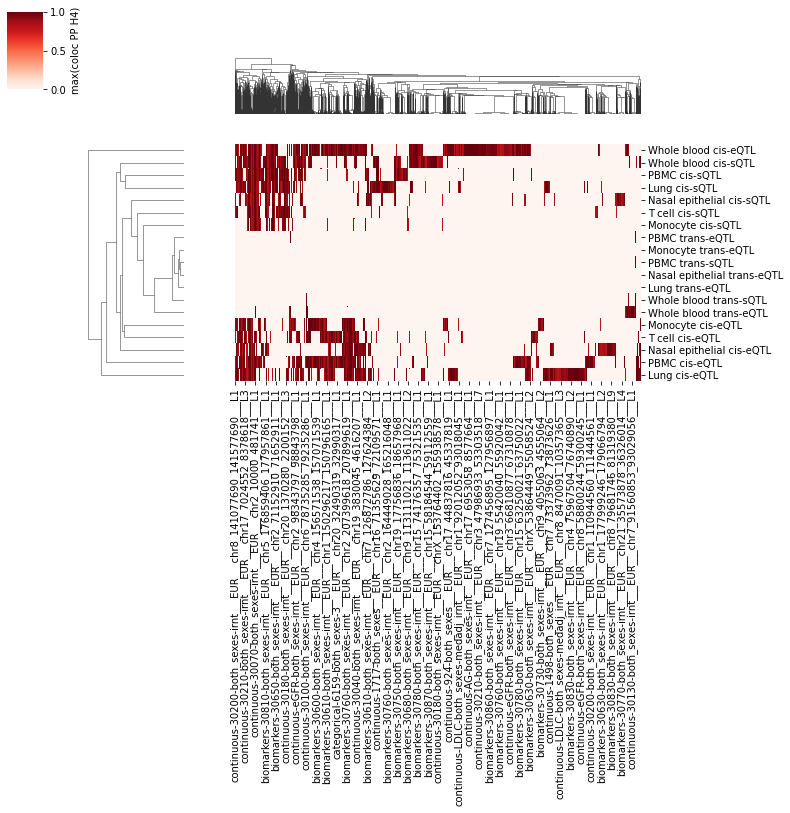

In [7]:
# compute dendogram and re-order the matrix accordingly
row_linkage = scipy_linkage(max_pp4_colocs, method='average', metric='euclidean', optimal_ordering=True)
col_linkage = fastcluster_linkage(max_pp4_colocs.T, method='average', metric='euclidean')
g = sns.clustermap(max_pp4_colocs, cmap='Reds', figsize=(10,6), cbar_kws={'label': 'max(coloc PP H4)'}, row_linkage=row_linkage, col_linkage=col_linkage)
row_order = g.dendrogram_row.reordered_ind
col_order = g.dendrogram_col.reordered_ind
max_pp4_colocs = max_pp4_colocs.iloc[row_order, col_order]
max_pp4_colocs.head()

In [8]:
palettes = {
    'tissue' : {
        'Whole_blood': '#1b9e77',
        'Nasal_epithelial': '#d95f02',
        'T_cell': '#7570b3',
        'Monocyte': '#e7298a',
        'PBMC': '#66a61e',
        'Lung': '#e6ab02'
    },
    'modality': {'cis-eQTL': colors.TABLEAU_COLORS['tab:blue'], 'cis-sQTL': colors.TABLEAU_COLORS['tab:red'], 'trans-eQTL': colors.TABLEAU_COLORS['tab:green'], 'trans-sQTL': colors.TABLEAU_COLORS['tab:purple']}
}

modality_and_tissue = max_pp4_colocs.index.to_frame()
modality_and_tissue['modality'] = max_pp4_colocs.index.map(lambda x: parse_index(x)['modality'])
modality_and_tissue['tissue'] = max_pp4_colocs.index.map(lambda x: parse_index(x)['tissue'])
modality_and_tissue = modality_and_tissue.drop(columns=0)
modality_and_tissue.tissue = modality_and_tissue.tissue.map(lambda x: palettes['tissue'][x.replace(' ', '_')])
modality_and_tissue.modality = modality_and_tissue.modality.map(palettes['modality'])
modality_and_tissue

,modality,tissue
Whole blood cis-eQTL,#1f77b4,#1b9e77
Whole blood cis-sQTL,#d62728,#1b9e77
PBMC cis-sQTL,#d62728,#66a61e
Lung cis-sQTL,#d62728,#e6ab02
Nasal epithelial cis-sQTL,#d62728,#d95f02
T cell cis-sQTL,#d62728,#7570b3
Monocyte cis-sQTL,#d62728,#e7298a
PBMC trans-eQTL,#2ca02c,#66a61e
Monocyte trans-eQTL,#2ca02c,#e7298a
PBMC trans-sQTL,#9467bd,#66a61e


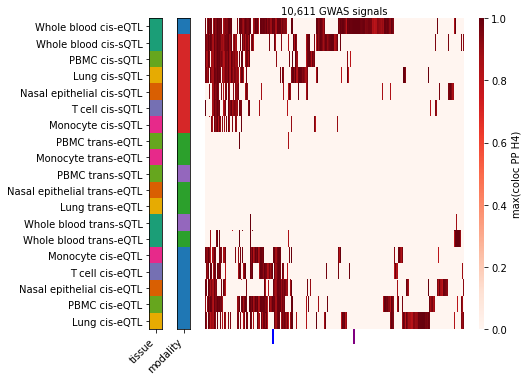

In [9]:
fig, axs = plt.subplots(ncols=4, nrows=2, figsize=(6,6), gridspec_kw={'width_ratios': [0.05, 0.05, 1, 0.02], 'height_ratios': [1, 0.05], 'hspace': 0})

axs[1,0].remove()
axs[1,1].remove()
axs[1,3].remove()

ax = axs[0,0]
ax.imshow(np.array([[list(hex_to_rgb(i))] for i in modality_and_tissue.tissue]), aspect='auto')
ax.set_xticks([0])
ax.set_xticklabels(['tissue'], rotation=45, ha='right')
ax.set_yticks(list(range(len(max_pp4_colocs))))
ax.set_yticklabels(max_pp4_colocs.index.to_list())

ax = axs[0,1]
ax.imshow(np.array([[list(hex_to_rgb(i))] for i in modality_and_tissue.modality]), aspect='auto')
ax.set_xticks([0])
ax.set_xticklabels(['modality'], rotation=45, ha='right')
ax.set_yticks([])

ax = axs[0,2]
sns.heatmap(max_pp4_colocs, ax=ax, cbar_ax=axs[0,3], cbar_kws={'label': 'max(coloc PP H4)'}, cmap='Reds')
ax.set_xticks([])
ax.xaxis.set_label_position('top')
ax.set_xlabel('{:,} GWAS signals'.format(max_pp4_colocs.shape[1]))
ax.set_yticks([])

ax = axs[1,2]
ax.set_xlim(axs[0,2].get_xlim())
for signal, color in zip(signals, signal_colors):
    ax.axvline(max_pp4_colocs.columns.to_list().index(signal), color=color, lw=2)
ax.axis('off')

fig.savefig(f'figures/{PREFIX}png', dpi=300, bbox_inches='tight')